In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-krylov-matrixfree)=
# Matrix-free iterations

A primary reason for our interest in matrices is their relationship to linear transformations. If we define $\mathbf{f}(\mathbf{x})=\mathbf{A}\mathbf{x}$, then for all vectors $\mathbf{x}$, $\mathbf{y}$, and scalars $\alpha$,

:::{math}
:label: lintrans
\begin{split}
\mathbf{f}(\mathbf{x} + \mathbf{y} ) &= \mathbf{f}(\mathbf{x}) + \mathbf{f}(\mathbf{y} ), \\
\mathbf{f}(\alpha \mathbf{x} ) & = \alpha\, \mathbf{f}(\mathbf{x}).
\end{split}
:::

These properties define a linear transformation. Moreover, *every* linear transformation between finite-dimensional vector spaces can be represented as a matrix-vector multiplication.

## Matrix-free iterations

In Chapter 4 we solved the nonlinear rootfinding problem $\mathbf{f}(\mathbf{x})=\boldsymbol{0}$ with methods that needed only the ability to evaluate $\mathbf{f}$ at any known value of $\mathbf{x}$. By repeatedly evaluating $\mathbf{f}$ at cleverly chosen points, these algorithms were able to return an estimate for $\mathbf{f}^{-1}(\boldsymbol{0})$.

A close examination reveals that the power method and Krylov subspace methods have the same structure because the only appearance of the matrix $\mathbf{A}$ in them is to multiply a known vector, i.e., to evaluate $\mathbf{f}(\mathbf{x})=\mathbf{A}\mathbf{x}$. This is used to evaluate the inverse, $\mathbf{A}^{-1}\mathbf{b}$. 

Bringing these points of view together leads us to a cornerstone of modern scientific computation: *matrix-free iterations*. Krylov subspace methods can be used to invert a linear transformation if one provides code for the transformation, even if its associated matrix is not known explicitly. 

## Blurring images

```{index} image (as a matrix)
```
In {numref}`section-matrixanaly-insight` we saw that a grayscale image can be represented as an $m\times n$ matrix $\mathbf{X}$ of pixel intensity values. Now consider a simple model for blurring the image. Define $\mathbf{B}$ as the $m\times m$ tridiagonal matrix

:::{math}
:label: blurmatrix
B_{ij} =
\begin{cases}
\tfrac{1}{2} & \text{if $i=j$},\\
\tfrac{1}{4} & \text{if $|i-j|=1$},\\
0 & \text{otherwise.}
\end{cases}
:::

The product $\mathbf{B}\mathbf{X}$ applies $\mathbf{B}$ to each column of $\mathbf{X}$. Within that column it does a weighted average of the values of each pixel and its two neighbors. That has the effect of blurring the image vertically. We can increase the amount of blur by applying $\mathbf{B}$ repeatedly.

In order to blur horizontally, we can transpose the image and apply blurring in the same way. We need a blurring matrix defined as in {eq}`blurmatrix` but with size $n\times n$. We call this matrix $\mathbf{C}$. Altogether the horizontal blurring is done by transposing, applying $\mathbf{C}$, and transposing back to the original orientation. That is,

:::{math}
\bigl(\mathbf{C} \mathbf{X}^T\bigr)^T = \mathbf{X}\mathbf{C}^T = \mathbf{X}\mathbf{C},
:::

using the symmetry of $\mathbf{C}$. So we can describe blur in both directions as the function

:::{math}
:label: blurfunction
\operatorname{blur}(\mathbf{X}) = \mathbf{B}^k \mathbf{X} \mathbf{C}^k
:::

for a positive integer $k$.

(demo-matrixfree-blur)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We use a readily available test image.

┌ Info: Precompiling TiffImages [731e570b-9d59-4bfa-96dc-6df516fadf69]
└ @ Base loading.jl:1423


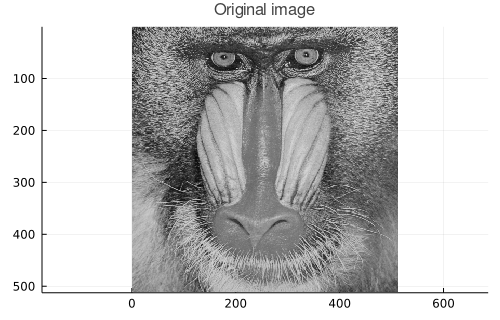

In [2]:
img = testimage("mandrill")
m,n = size(img)
X = @. Float64(Gray(img))
plot(Gray.(X),title="Original image",aspect_ratio=1)

We define the one-dimensional tridiagonal blurring matrices.

In [3]:
function blurmatrix(d)
    v1 = fill(0.25,d-1)
    return spdiagm(0=>fill(0.5,d), 1=>v1, -1=>v1)
end
B,C = blurmatrix(m),blurmatrix(n);

Finally, we show the results of using $k=12$ repetitions of the blur in each direction.

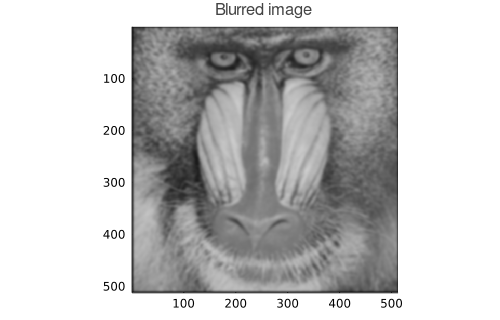

In [4]:
blur = X -> B^12 * X * C^12;
Z = blur(X)
plot(Gray.(Z),title="Blurred image")

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```


## Deblurring

A more interesting operation is *deblurring*: given an image blurred by poor focus, can we reconstruct the true image? Conceptually, we want to invert the function $\operatorname{blur}(\mathbf{X})$.

It's easy to see from {eq}`blurfunction` that the blur operation is a linear transformation on image matrices. But an $m\times n$ image matrix is equivalent to a length-$mn$ vector—it's just a matter of interpreting the shape of the same data. Let $\operatorname{vec}(\mathbf{X})=\mathbf{x}$ and $\operatorname{unvec}(\mathbf{x})=\mathbf{X}$ be the mathematical statements of such reshaping operations. Now say $\mathbf{X}$ is the original image and $\mathbf{Z}=\operatorname{blur}(\mathbf{X})$ is the blurred one. Then by linearity there is some matrix $\mathbf{A}$ such that

:::{math}
\mathbf{A} \operatorname{vec}(\mathbf{X}) = \operatorname{vec}(\mathbf{Z}),
:::

or $\mathbf{A}\mathbf{x}=\mathbf{z}$.

The matrix $\mathbf{A}$ is $mn\times mn$; for a 12-megapixel image, it would have $1.4\times 10^{14}$ entries! Admittedly, it is extremely sparse, but the point is that we don't need it at all. 

Instead, given any vector $\mathbf{u}$ we can compute $\mathbf{v}=\mathbf{A}\mathbf{u}$ through the steps

\begin{align*}
  \mathbf{U} &= \operatorname{unvec}(\mathbf{u}),\\
  \mathbf{V} &= \operatorname{blur}(\mathbf{U}),\\
  \mathbf{v} &= \operatorname{vec}(\mathbf{V}).
\end{align*}

The following example shows how to put these ideas into practice with MINRES.

(demo-matrixfree-deblur)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```


We repeat the earlier process to blur an original image $\mathbf{X}$ to get $\mathbf{Z}$.

┌ Info: Precompiling PNGFiles [f57f5aa1-a3ce-4bc8-8ab9-96f992907883]
└ @ Base loading.jl:1423


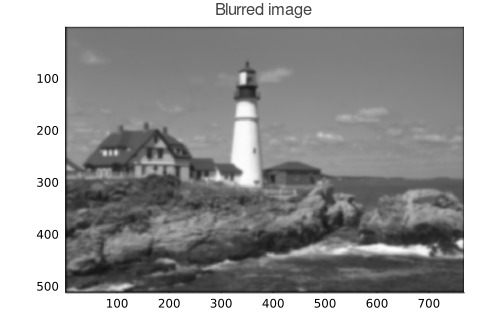

In [5]:
img = testimage("lighthouse")
m,n = size(img)
X = @. Float64(Gray(img))

B = spdiagm(0=>fill(0.5,m),
        1=>fill(0.25,m-1),-1=>fill(0.25,m-1))
C = spdiagm(0=>fill(0.5,n),
        1=>fill(0.25,n-1),-1=>fill(0.25,n-1))
blur = X -> B^12 * X * C^12
Z = blur(X)
plot(Gray.(Z),title="Blurred image")

Now we imagine that $\mathbf{X}$ is unknown and that we want to recover it from $\mathbf{Z}$. We first need functions that translate between vector and matrix representations.

In [6]:
# vec (built-in) converts matrix to vector
unvec = z -> reshape(z,m,n);  # convert vector to matrix

```{index} ! Julia; LinearMap
```

Now we declare the three-step blur transformation as a `LinearMap`, supplying also the size of the vector form of an image.

In [7]:
T = LinearMap(x -> vec(blur(unvec(x))),m*n);

::::{panels}
:column: col-7 left-side
:card: border-0 shadow-none
```{raw} latex
\begin{minipage}[t]{0.5\textwidth}
```
The blurring operators are symmetric, so we apply `minres` to the composite blurring transformation `T`.

```{raw} latex
\end{minipage}\hfill
```
---
:column: col-5 right-side
:card: shadow-none comment
```{raw} latex
\begin{minipage}[t]{0.4\textwidth}\begin{mdframed}[default]\small
```
The function `clamp01` in `Images` restricts values to be in the interval $[0,1]$.
```{raw} latex
\end{mdframed}\end{minipage}
```
::::

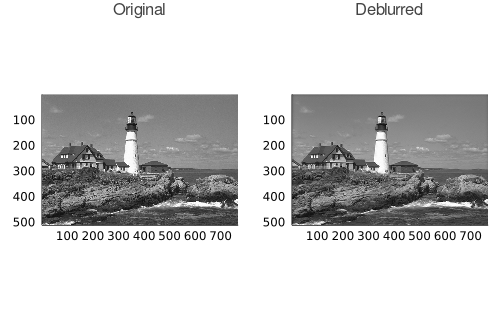

In [8]:
y = minres(T,vec(Z),maxiter=50,reltol=1e-5);
Y = unvec( clamp01.(y) )

plot(Gray.(X),layout=2,title="Original")
plot!(Gray.(Y),subplot=2,title="Deblurred")

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```


## Exercises

1. ✍ Show using {eq}`lintrans` and {eq}`blurfunction` that the blur operation is a linear transformation. 

2. ✍ In each case, state with reasons whether the given transformation on $n$-vectors is linear. 

    **(a)** $\,\mathbf{f}(\mathbf{x}) = \begin{bmatrix} x_2\\x_3 \\\vdots\\ x_n \\ x_1 \end{bmatrix}\qquad$
    **(b)** $\,\mathbf{f}(\mathbf{x}) = \begin{bmatrix} x_1\\x_1+x_2\\x_1+x_2+x_3\\\vdots\\x_1+\cdots+x_n \end{bmatrix} \qquad$
    **(c)** $\,\mathbf{f}(\mathbf{x}) = \begin{bmatrix} x_1 + 1 \\x_2 + 2 \\ x_3 + 3 \\\vdots \\ x_n+n \end{bmatrix} \qquad$
    **(d)** $\,\mathbf{f}(\mathbf{x}) = \|\mathbf{x}\|_\infty\, \mathbf{e}_1$

3. ✍ Suppose that code for the linear transformation $\mathbf{f}(\mathbf{x})=\mathbf{A}\mathbf{x}$ is given for an unknown matrix $\mathbf{A}$. Explain carefully how one could construct $\mathbf{A}$.

4. ⌨ The matrix of the blur transformation happens to be symmetric and positive definite. Repeat {numref}`Demo %s <demo-matrixfree-deblur>` using CG for the deblurring.

5. The condition number of the matrix of the blur transformation is related to the condition numbers of the single-dimension matrices $\mathbf{B}^k$ and $\mathbf{C}^k$ in {eq}`blurfunction`.

    **(a)** ⌨  Let $m=50$. Show that $\mathbf{B}$ has a Cholesky factorization and thus is SPD. Find $\kappa(\mathbf{B})$. (Note: `cond` requires a regular dense matrix, not a sparse matrix.)

    **(b)** ✍ Explain why part (a) implies $\kappa( \mathbf{B}^k ) = \kappa(\mathbf{B})^k$.

    **(c)** ✍ Explain two important effects of the limit $k\to \infty$ on deblurring by Krylov methods. 

6. The cumulative summation function `cumsum` is defined as

    $$
    \mathbf{f}(\mathbf{x}) = \begin{bmatrix} x_1 \\ x_1+x_2 \\ \vdots \\ x_1 + x_2 + \cdots + x_n \end{bmatrix}.
    $$

    **(a)** ✍ Show that $\mathbf{f}$ is a linear transformation.

    **(b)** ⌨ Define vector $\mathbf{b}$ by $b_i = (i/100)^2$ for $i=1,\ldots,100$. Then use `gmres` to find $\mathbf{x}=\mathbf{f}^{-1}(\mathbf{b})$. 

    **(c)** ⌨ Plot $\mathbf{x}$, and explain why the result looks as it does.